In [1]:
import pandas, numpy, seaborn, umap
import scipy, scipy.signal
import sklearn, sklearn.cluster
import MulticoreTSNE

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

# user-defined variables

In [3]:
expression_file = '/home/adrian/scratch/selected_expression.tsv'
output_dir = '/home/adrian/scratch/'

In [4]:
iso1 = 'ENST00000354449.7'
iso2 = 'ENST00000354956.9'

# read data

In [5]:
%%time
selected_expression = pandas.read_csv(expression_file, index_col=0, sep='\t')
print(selected_expression.shape)
selected_expression.head()

(46490, 4850)
CPU times: user 31.2 s, sys: 1.14 s, total: 32.3 s
Wall time: 32.3 s


GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
sample                                                                
ENST00000625998.2                 2.172597                 2.098120   
ENST00000583693.5                 1.679476                 1.659720   
ENST00000012134.6                 0.028054                 1.528813   
ENST00000403263.5                 2.737514                 2.433423   
ENST00000449352.6                 1.695411                 2.800497   

                   GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
sample                                                                 
ENST00000625998.2                  0.604361                 1.012243   
ENST00000583693.5                  2.343766                 2.182024   
ENST00000012134.6                  1.308149                 0.799196   
ENST00000403263.5                  2.221165                 2.084570   
ENST00000449352.6                  2.215746                 2.359610   

                   GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
sample                                                                 
ENST00000625998.2                 2.112940                  1.282651   
ENST00000583693.5                 1.608522                  2.342481   
ENST00000012134.6                 2.200149                  1.650502   
ENST00000403263.5                 2.304542                  2.238873   
ENST00000449352.6                 2.831991                  2.112632   

                   GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
sample                                                                
ENST00000625998.2                 2.350597                 1.055977   
ENST00000583693.5                 1.919266                 2.462014   
ENST00000012134.6                 1.646210                 2.311007   
ENST00000403263.5                 2.688859                 2.615937   
ENST00000449352.6                 2.839560                 2.607822   

                   GTEX-11ONC-2326-SM-5HL6P  GTEX-TSE9-0126-SM-3DB83  ...  \
sample                                                                ...   
ENST00000625998.2                  2.268121                 3.637061  ...   
ENST00000583693.5                  1.688779                 2.058498  ...   
ENST00000012134.6                  2.369605                 2.471435  ...   
ENST00000403263.5                  2.220693                 2.446559  ...   
ENST00000449352.6                  2.999159                 2.933138  ...   

                   GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
sample                                                                  
ENST00000625998.2                  0.979851                  2.130198   
ENST00000583693.5                  2.027438                  1.520067   
ENST00000012134.6                  1.576889                  1.827558   
ENST00000403263.5                  2.220222                  2.060171   
ENST00000449352.6                  3.785498                  1.353480   

                   GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
sample                                                                 
ENST00000625998.2                  1.992097                 1.513298   
ENST00000583693.5                  1.725912                 2.402364   
ENST00000012134.6                  2.260518                 1.542512   
ENST00000403263.5                  2.130275                 2.778681   
ENST00000449352.6                  2.671217                 2.489579   

                   GTEX-ZYFD-2126-SM-5E43D  GTEX-OOBK-2626-SM-2HMKY  \
sample                                                                
ENST00000625998.2                 0.000141                 1.761416   
ENST00000583693.5                 2.017785                 2.313324   
ENST00000012134.6                 3.450004                 2.087475   
ENST00000403263.5                 2.242817                 1.937410   
ENST00000449352.6             

# quantile normalization

In [6]:
%%time
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(selected_expression.values, axis=0), index=selected_expression.index, columns=selected_expression.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = selected_expression.rank(method="min").stack().astype(int).map(df_mean).unstack()

CPU times: user 57.4 s, sys: 6.79 s, total: 1min 4s
Wall time: 1min 4s


14.632557278189001
4850


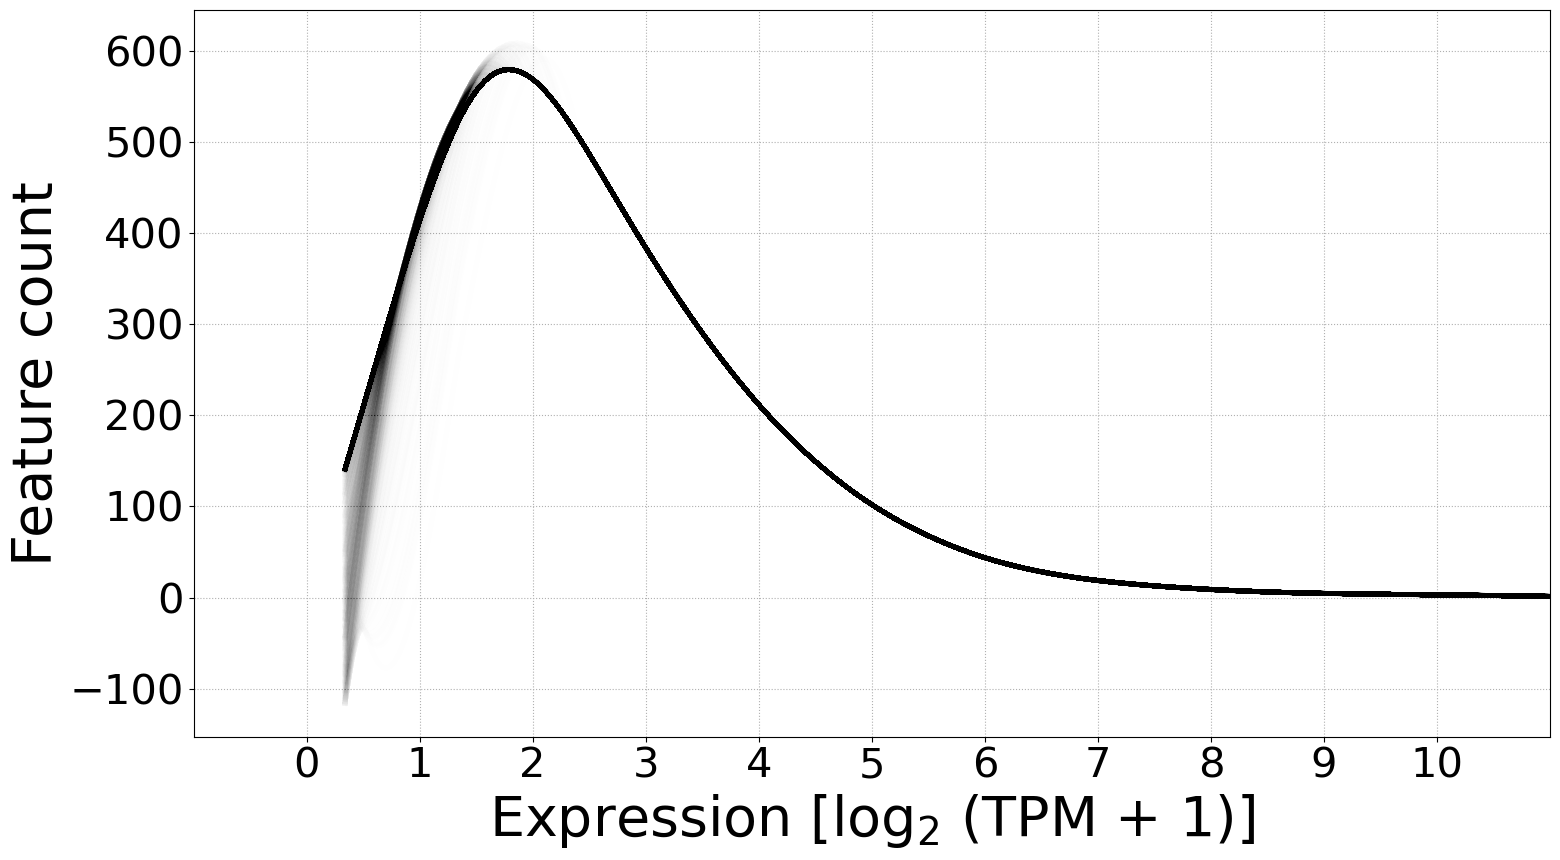

In [7]:
found_max = 19
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/3)

most_likely_expressions = []

selected_samples = []

for sample in qndf.columns:
        
    expression_values = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # determine most likely expression
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    # sample selection
    if 1 <= most_likely_expression <= 2:
        selected_samples.append(sample)
    
    # plotting
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='black')
    
    # check
    if numpy.max(expression_values) > absolute_max:
        absolute_max = numpy.max(expression_values)

# check print
print(absolute_max)
print(len(selected_samples))

matplotlib.pyplot.xlim(-1, 11)                  
matplotlib.pyplot.xticks(range(0, 10+1))
matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [8]:
# define highly variable genes.plot cv as a fucntion of mean.
# http://pklab.med.harvard.edu/scw2014/subpop_tutorial.html

# z-score

In [9]:
zscore_df = scipy.stats.zscore(qndf, axis=1)
zscore_df.std(axis=1)

sample
ENST00000625998.2    1.000103
ENST00000583693.5    1.000103
ENST00000012134.6    1.000103
ENST00000403263.5    1.000103
ENST00000449352.6    1.000103
                       ...   
ENST00000470412.5    1.000103
ENST00000469534.1    1.000103
ENST00000507412.1    1.000103
ENST00000568351.1    1.000103
ENST00000491408.1    1.000103
Length: 46490, dtype: float64

In [10]:
print(zscore_df.max().max())
print(zscore_df.min().min())

16.035577237299698
-17.83257350906713


# exploratory visualization

## heatmap

In [11]:
zscore_df.rename_axis('Transcripts', inplace=True)
zscore_df.rename_axis('Samples', axis='columns', inplace=True)
print(zscore_df.shape)
zscore_df

(46490, 4850)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000625998.2                 0.263048                 0.099419   
ENST00000583693.5                -0.073850                -0.310748   
ENST00000012134.6                -1.832807                -0.252275   
ENST00000403263.5                 1.872036                 0.861516   
ENST00000449352.6                -0.728935                 0.382982   
...                                    ...                      ...   
ENST00000470412.5                -0.329007                -0.684363   
ENST00000469534.1                -0.616457                -0.462084   
ENST00000507412.1                 1.291458                 1.744660   
ENST00000568351.1                -1.200862                 0.183297   
ENST00000491408.1                -0.615953                 0.994024   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000625998.2                 -2.526438                -1.804144   
ENST00000583693.5                  0.448507                 0.500200   
ENST00000012134.6                 -1.107070                -1.662162   
ENST00000403263.5                 -0.852487                -0.720786   
ENST00000449352.6                 -0.663683                -0.265099   
...                                     ...                      ...   
ENST00000470412.5                  1.524939                -0.879398   
ENST00000469534.1                 -1.147812                -1.246140   
ENST00000507412.1                 -0.880080                -0.764095   
ENST00000568351.1                  0.693915                 0.779682   
ENST00000491408.1                 -0.528379                -0.247230   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000625998.2                -0.130980                 -1.460529   
ENST00000583693.5                -1.070835                  0.799277   
ENST00000012134.6                 0.325733                 -0.516594   
ENST00000403263.5                -0.026809                 -0.379251   
ENST00000449352.6                 0.265950                 -0.636996   
...                                    ...                       ...   
ENST00000470412.5                -0.308284                  1.673239   
ENST00000469534.1                -0.451648                 -0.461631   
ENST00000507412.1                 1.608494                 -0.088140   
ENST00000568351.1                -0.287498                  0.702218   
ENST00000491408.1                -0.230836                 -0.609542   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000625998.2                 0.692229                -1.985062   
ENST00000583693.5                 0.690695                 0.664133   
ENST00000012134.6                 0.027541                 0.171570   
ENST00000403263.5                 2.305309                 0.342521   
ENST00000449352.6                 0.699918                -0.223612   
...                                    ...                      ...   
ENST00000470412.5                 0.619182                -0.852590   
ENST00000469534.1                 0.588264                -0.902669   
ENST00000507412.1                -1.121306                -0.761196   
ENST00000568351.1                 0.148664                 1.083099   
ENST00000491408.1                 0.470572                 0.137647   

Samples            GTEX-11ONC-2326-SM-5HL6P  GTEX-TSE9-0126-SM-3DB83  ...  \
Transcripts                                                           ...   
ENST00000625998.2                 -0.001303                 2.130159  ...   
ENST00000583693.5                 -1.152902    

In [12]:
# reduction of 10 runs for 68 CPU s
# reduction of 3 runs for 7 CPU min

print(zscore_df.shape)

reduction = 10
test = zscore_df.iloc[:int(zscore_df.shape[0]/reduction), :] 

print(test.shape)
test.tail()

(46490, 4850)
(4649, 4850)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000348849.7                -1.648367                 0.622758   
ENST00000589795.1                -0.291642                 0.607763   
ENST00000562949.1                 0.218163                 0.446954   
ENST00000251412.7                -1.060048                -0.218945   
ENST00000542575.6                 0.520684                 0.688190   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000348849.7                 -0.739115                 0.258223   
ENST00000589795.1                  0.084599                -0.707091   
ENST00000562949.1                  0.248116                -0.077143   
ENST00000251412.7                  0.332022                -0.288792   
ENST00000542575.6                 -1.423243                -0.393104   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000348849.7                -0.185615                  0.899691   
ENST00000589795.1                 1.276052                 -0.663979   
ENST00000562949.1                 0.593208                 -0.015268   
ENST00000251412.7                 0.349859                 -0.420163   
ENST00000542575.6                -0.179835                  1.141826   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000348849.7                -0.559297                -0.529517   
ENST00000589795.1                -0.466969                -1.041884   
ENST00000562949.1                 0.756836                 0.635139   
ENST00000251412.7                -1.956985                -0.289751   
ENST00000542575.6                -0.173247                -1.174500   

Samples            GTEX-11ONC-2326-SM-5HL6P  GTEX-TSE9-0126-SM-3DB83  ...  \
Transcripts                                                           ...   
ENST00000348849.7                 -0.112998                -0.245164  ...   
ENST00000589795.1                  2.026985                -0.620593  ...   
ENST00000562949.1                  0.147095                 0.977166  ...   
ENST00000251412.7                  0.786048                -0.944984  ...   
ENST00000542575.6                  0.073523                 0.094377  ...   

Samples            GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
Transcripts                                                             
ENST00000348849.7                 -0.493947                  0.839108   
ENST00000589795.1                 -0.577655                  0.208666   
ENST00000562949.1                 -0.096051                 -0.800383   
ENST00000251412.7                  0.100342                  0.585593   
ENST00000542575.6                 -1.024686                  0.218473   

Samples            GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
Transcripts                                                            
ENST00000348849.7                 -0.975918                 0.295793   
ENST00000589795.1                  0.900525                -1.093908   
ENST00000562949.1                 -0.010027                -1.420183   
ENST00000251412.7                  0.883616                -0.152750   
ENST00000542575.6                 -1.330646                 1.145503   

Samples            GTEX-ZYFD-2126-SM-5E43D  GTEX-OOBK-2626-SM-2HMKY  \
Transcripts                                                           
ENST00000348849.7                 0.762428                -0.244204   
ENST00000589795.1                 0.844466                -1.391945   
ENST00000562949.1                -0.540378                 1.283297   
ENST00000251412.7                -0.038592                -0.742730   
ENST0000054

In [13]:
nomiss = zscore_df.loc[[iso1, iso2], :]
print(test.shape)
print(nomiss.shape)
test = pandas.concat([test, nomiss])
print(test.shape)
test.tail()

(4649, 4850)
(2, 4850)
(4651, 4850)


Samples            GTEX-S4Q7-0003-SM-3NM8M  GTEX-QV31-1626-SM-2S1QC  \
Transcripts                                                           
ENST00000562949.1                 0.218163                 0.446954   
ENST00000251412.7                -1.060048                -0.218945   
ENST00000542575.6                 0.520684                 0.688190   
ENST00000354449.7                -3.096495                 0.351546   
ENST00000354956.9                 1.060372                 0.533415   

Samples            GTEX-13OW5-0626-SM-5J2N2  GTEX-ZPCL-0126-SM-4WWC8  \
Transcripts                                                            
ENST00000562949.1                  0.248116                -0.077143   
ENST00000251412.7                  0.332022                -0.288792   
ENST00000542575.6                 -1.423243                -0.393104   
ENST00000354449.7                 -1.373179                 0.287188   
ENST00000354956.9                 -1.116187                -0.783278   

Samples            GTEX-X88G-0426-SM-47JZ5  GTEX-1399S-1726-SM-5L3DI  \
Transcripts                                                            
ENST00000562949.1                 0.593208                 -0.015268   
ENST00000251412.7                 0.349859                 -0.420163   
ENST00000542575.6                -0.179835                  1.141826   
ENST00000354449.7                 0.614263                 -0.142409   
ENST00000354956.9                -1.187550                  0.832062   

Samples            GTEX-ZF29-0926-SM-4WKFZ  GTEX-WHPG-0226-SM-3NMB9  \
Transcripts                                                           
ENST00000562949.1                 0.756836                 0.635139   
ENST00000251412.7                -1.956985                -0.289751   
ENST00000542575.6                -0.173247                -1.174500   
ENST00000354449.7                 0.588742                 0.216477   
ENST00000354956.9                 0.876940                -1.064706   

Samples            GTEX-11ONC-2326-SM-5HL6P  GTEX-TSE9-0126-SM-3DB83  ...  \
Transcripts                                                           ...   
ENST00000562949.1                  0.147095                 0.977166  ...   
ENST00000251412.7                  0.786048                -0.944984  ...   
ENST00000542575.6                  0.073523                 0.094377  ...   
ENST00000354449.7                  1.163674                 1.049203  ...   
ENST00000354956.9                 -0.916227                 1.008328  ...   

Samples            GTEX-144GO-0126-SM-5LUAO  GTEX-1313W-1626-SM-5J1OE  \
Transcripts                                                             
ENST00000562949.1                 -0.096051                 -0.800383   
ENST00000251412.7                  0.100342                  0.585593   
ENST00000542575.6                 -1.024686                  0.218473   
ENST00000354449.7                  0.072720                 -0.893722   
ENST00000354956.9                 -0.958321                 -0.890059   

Samples            GTEX-12ZZY-1526-SM-5LZWF  GTEX-QMRM-0826-SM-3NB33  \
Transcripts                                                            
ENST00000562949.1                 -0.010027                -1.420183   
ENST00000251412.7                  0.883616                -0.152750   
ENST00000542575.6                 -1.330646                 1.145503   
ENST00000354449.7                  0.520175                 0.476581   
ENST00000354956.9                 -1.187550                 0.302309   

Samples            GTEX-ZYFD-2126-SM-5E43D  GTEX-OOBK-2626-SM-2HMKY  \
Transcripts                                                           
ENST00000562949.1                -0.540378                 1.283297   
ENST00000251412.7                -0.038592                -0.742730   
ENST00000542575.6                -0.516850                 0.230286   
ENST00000354449.7                 0.756962                -0.117995   
ENST0000035

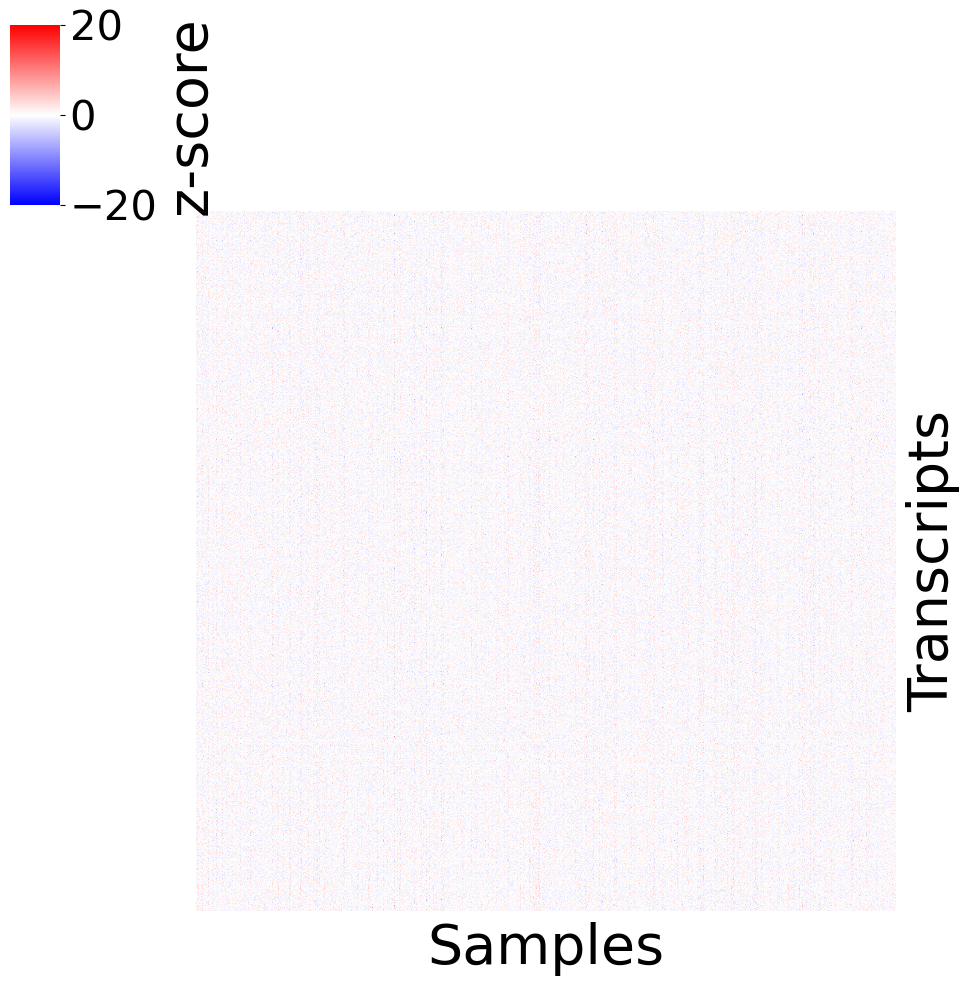

CPU times: user 10.4 s, sys: 327 ms, total: 10.8 s
Wall time: 10.8 s


In [14]:
%%time
seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=False, 
                   col_cluster=False, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                  )
matplotlib.pyplot.show()

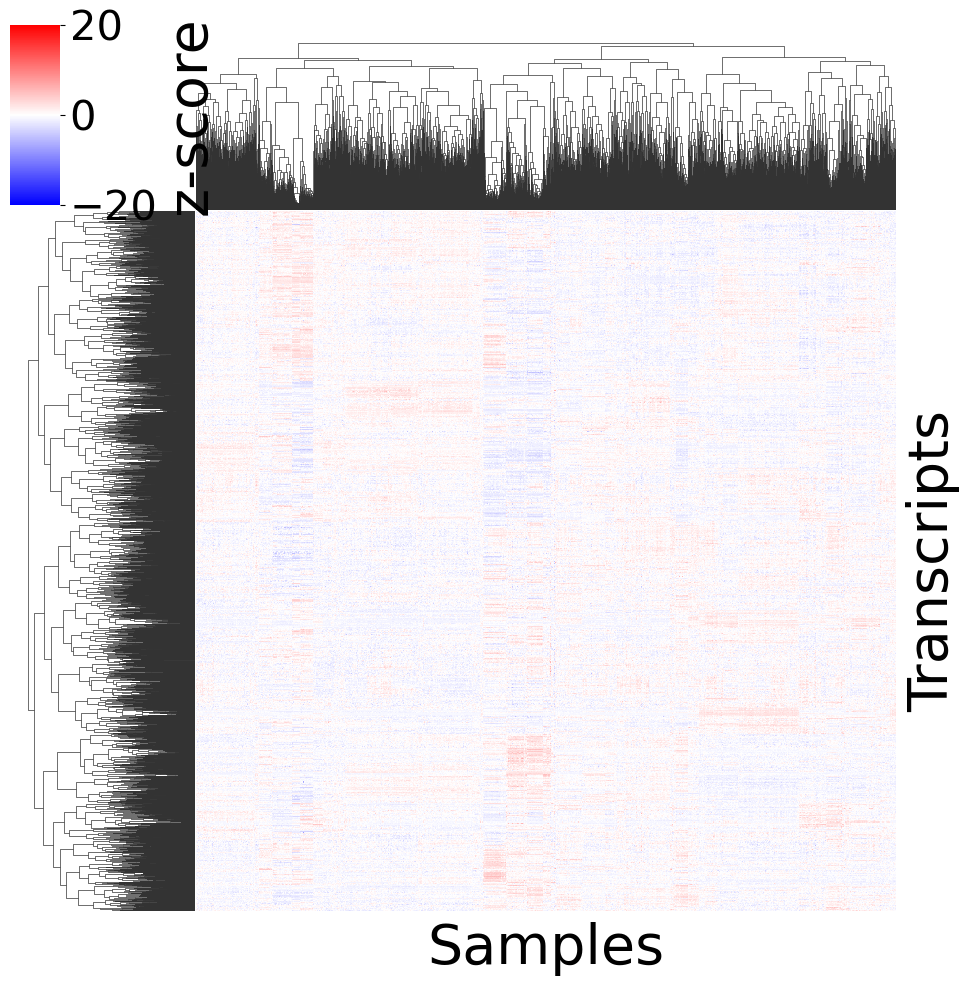

CPU times: user 1min 7s, sys: 300 ms, total: 1min 7s
Wall time: 1min 7s


In [15]:
%%time
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric
                  )
matplotlib.pyplot.show()

## dimensionality reduction

### UMAP

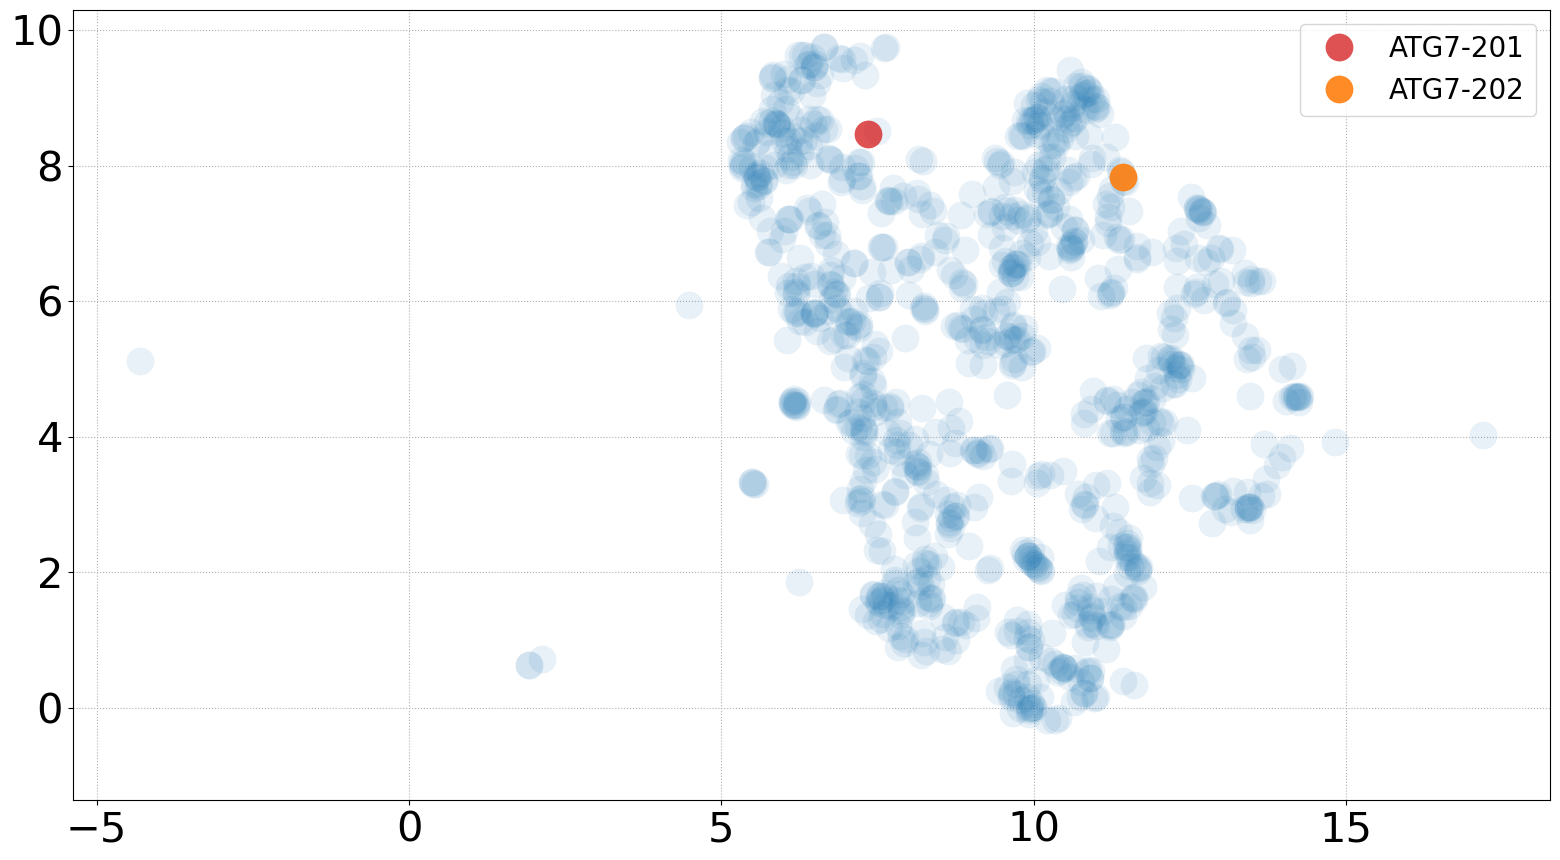

(4651, 2)
CPU times: user 36.3 s, sys: 138 ms, total: 36.4 s
Wall time: 11 s


X         Y
Transcripts                           
ENST00000625998.2  10.917321  0.535610
ENST00000583693.5   8.915119  1.326019
ENST00000012134.6   6.735055  5.974454
ENST00000403263.5  11.506751  1.656873
ENST00000449352.6   9.375940  5.885629
...                      ...       ...
ENST00000562949.1   9.744754  6.800854
ENST00000251412.7   6.642081  6.137460
ENST00000542575.6  11.438367  7.605152
ENST00000354449.7   7.345786  8.462913
ENST00000354956.9  11.420362  7.836166

[4651 rows x 2 columns]

In [16]:
%%time
runUmap = umap.UMAP(metric='correlation',
                    n_neighbors=5,
                    min_dist=0,
                    learning_rate=0.5
                   ).fit_transform
dr_umap = runUmap(test)
positionsu = pandas.DataFrame(dr_umap, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionsu['X'], positionsu['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20, markevery=5)

matplotlib.pyplot.plot(positionsu.loc[iso1, 'X'], positionsu.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionsu.loc[iso2, 'X'], positionsu.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(positionsu.shape)
positionsu

### tSNE

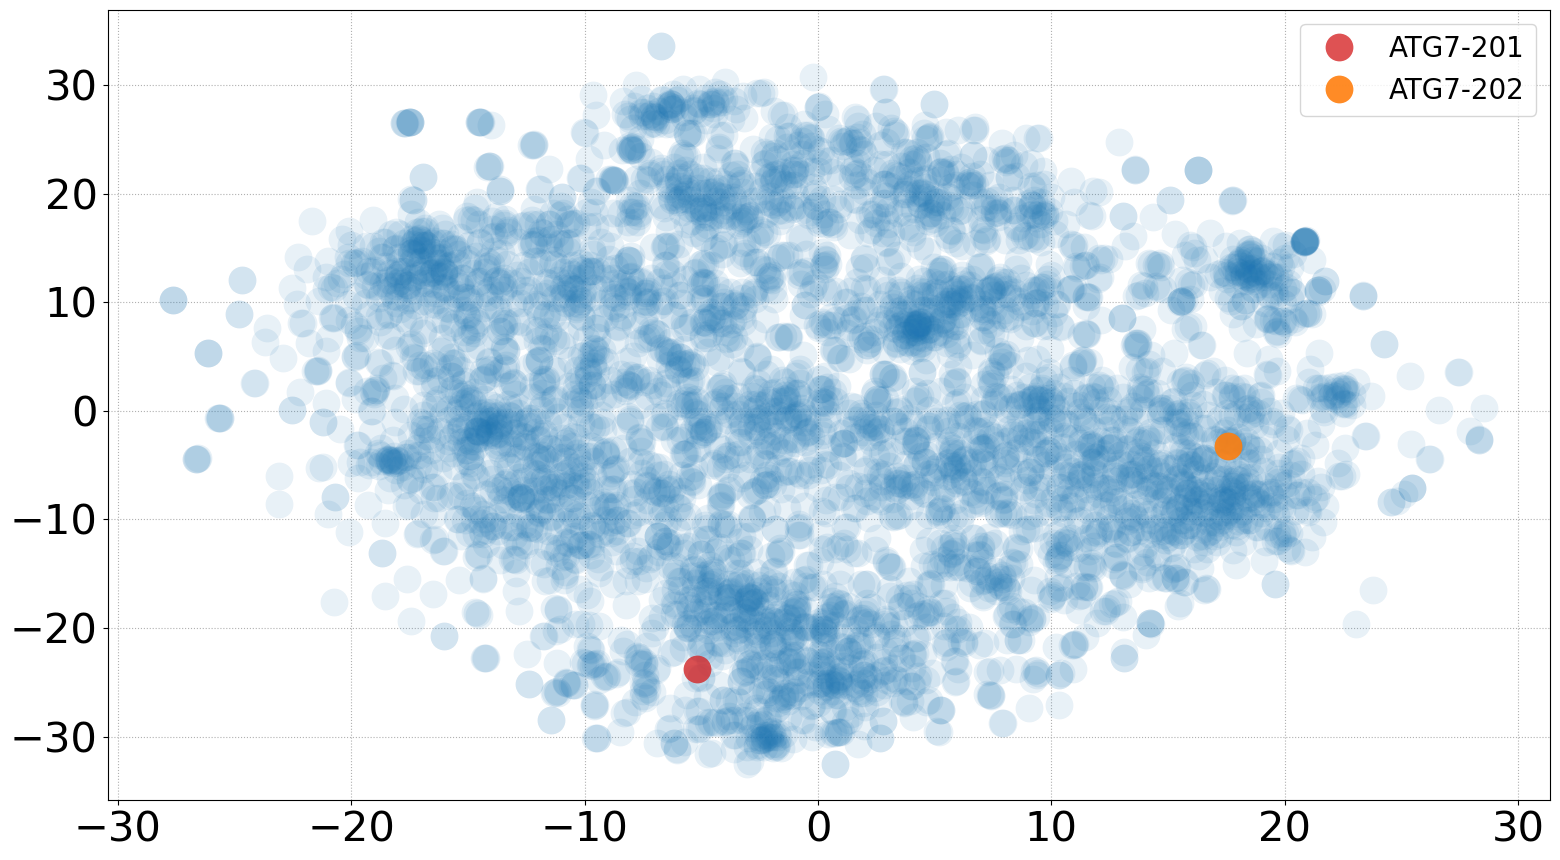

CPU times: user 8min 14s, sys: 2min 20s, total: 10min 34s
Wall time: 32.9 s


In [17]:
%%time
tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=20)
dr_tsne = tsne.fit_transform(test)
positionst = pandas.DataFrame(dr_tsne, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionst['X'], positionst['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.plot(positionst.loc[iso1, 'X'], positionst.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionst.loc[iso2, 'X'], positionst.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# cluster data

In [18]:
%%time 
all_ks = range(2, 150)
successes = []; all_ss = [];  all_khi = []; all_dbi = []
groupings = []
for k in all_ks:
    
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(test)
    
    # deterimine success
    results = pandas.DataFrame(kmeans.labels_, columns=['label'], index=test.index)
    if results.loc[iso1, 'label'] == results.loc[iso2, 'label']:
        success = 0
    else:
        success = 1
    successes.append(success)
    
    # calculate and store goodness indices
    ss = sklearn.metrics.silhouette_score(test, kmeans.labels_, metric='correlation')
    khi = sklearn.metrics.calinski_harabasz_score(test, kmeans.labels_)
    dbi = sklearn.metrics.davies_bouldin_score(test, kmeans.labels_)
    all_ss.append(ss); all_khi.append(khi); all_dbi.append(dbi)

    # store partitions
    groupings.append(kmeans.labels_)

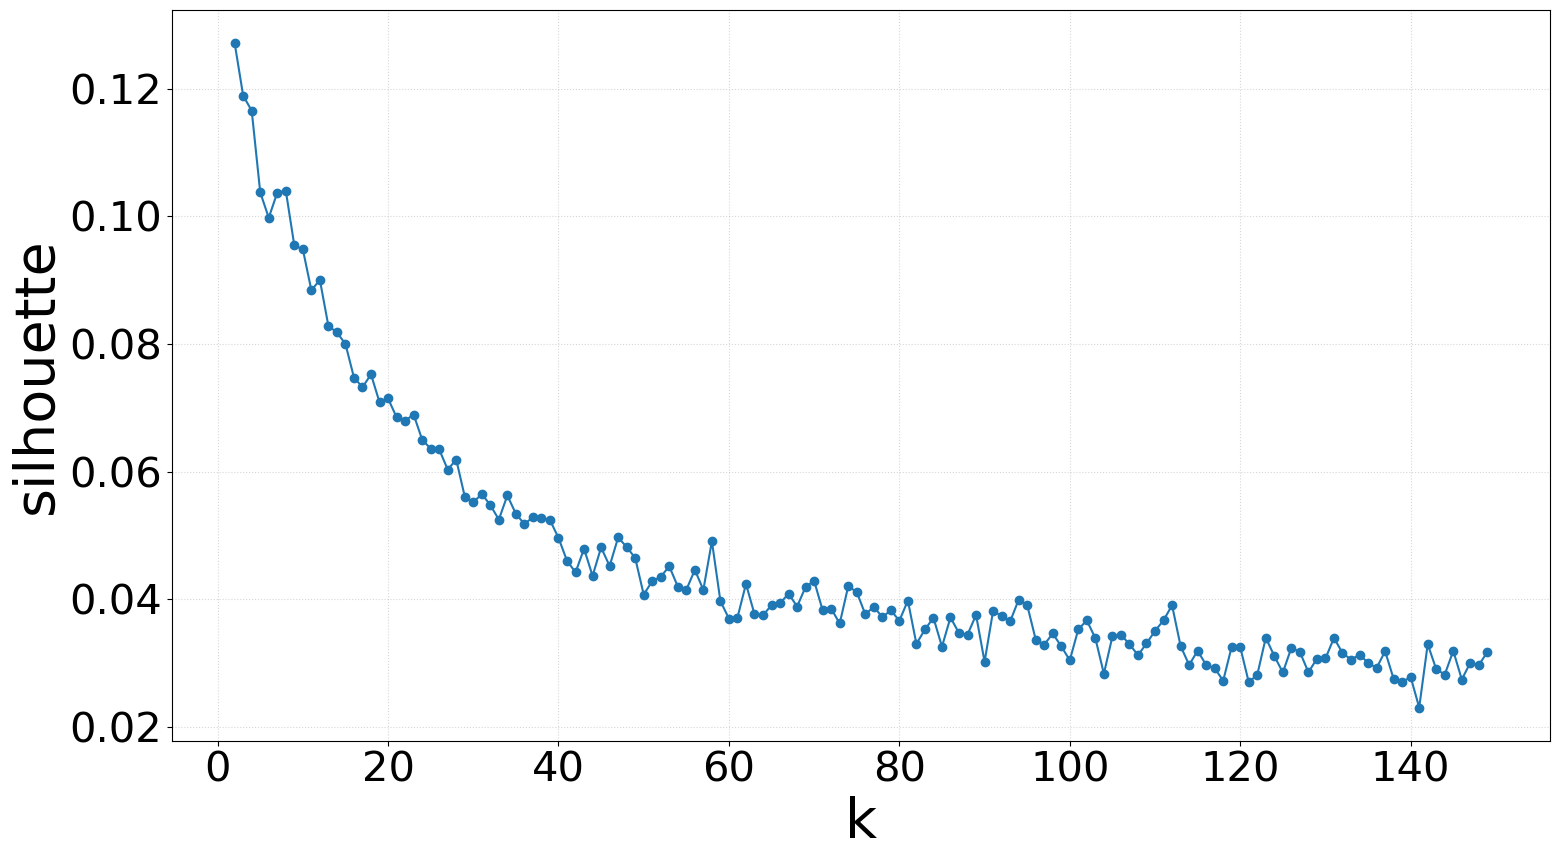

In [30]:
# silhouette: between -1 and 1, 0 being indiferent, 1 very good.
matplotlib.pyplot.plot(all_ks, all_ss, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('silhouette')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

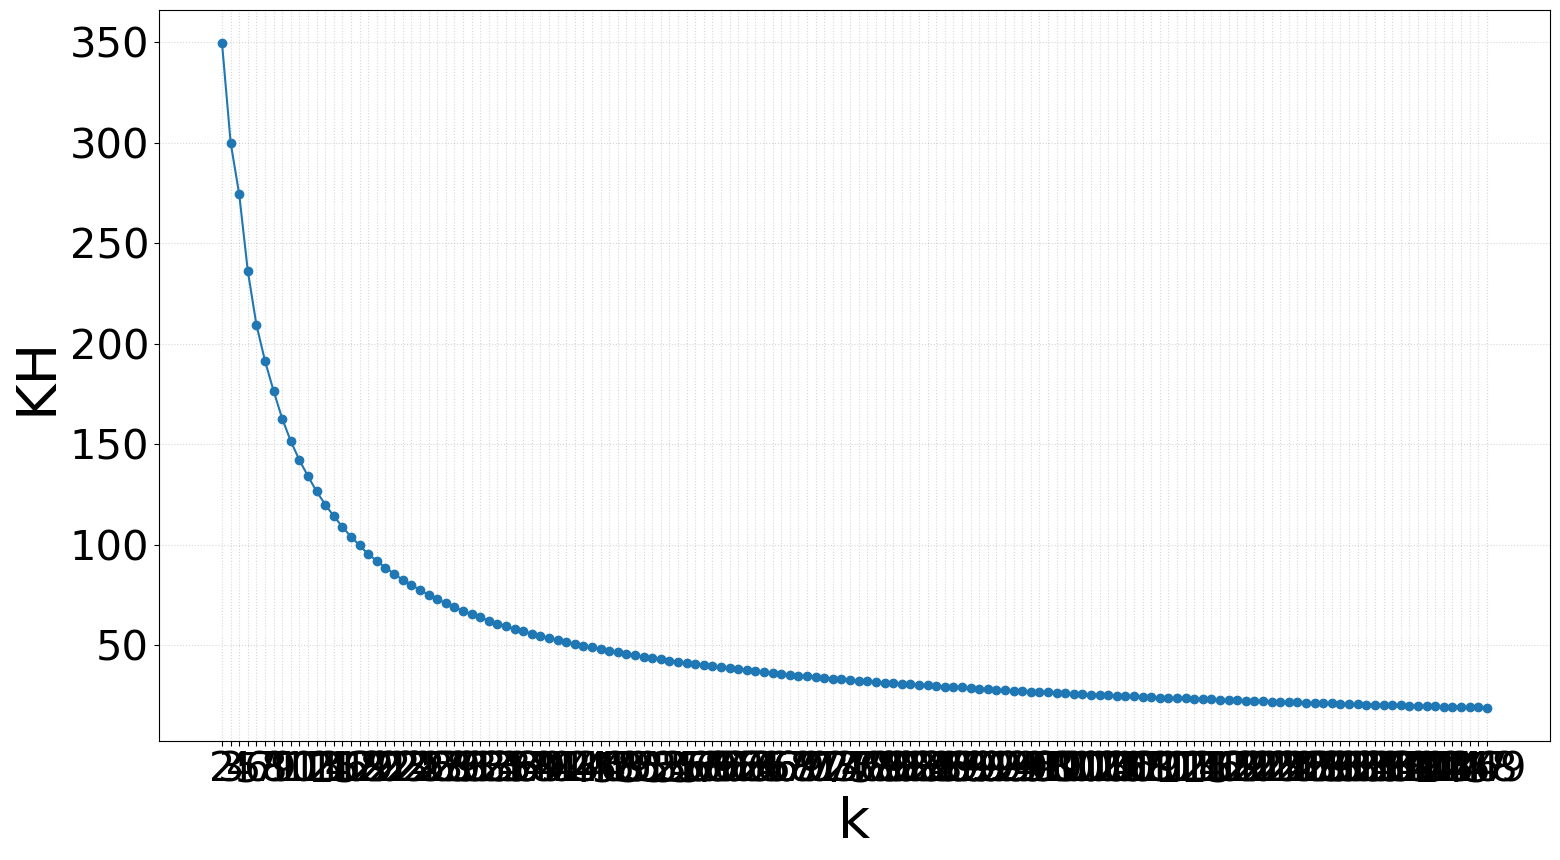

In [20]:
matplotlib.pyplot.plot(all_ks, all_khi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('KH')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

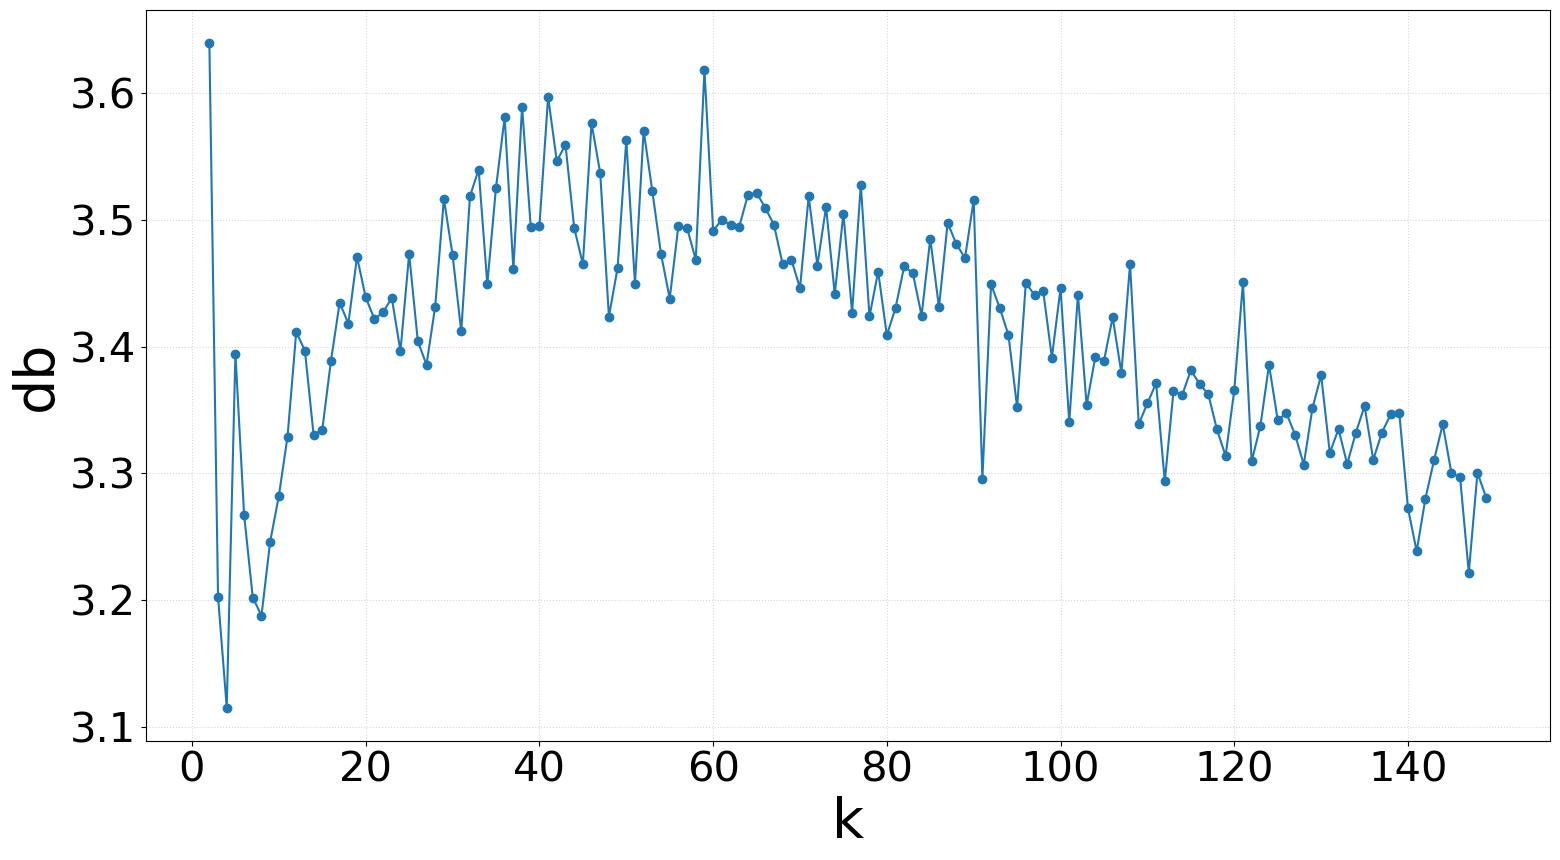

In [29]:
# The minimum score is zero, with lower values indicating better clustering.
matplotlib.pyplot.plot(all_ks, all_dbi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('db')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

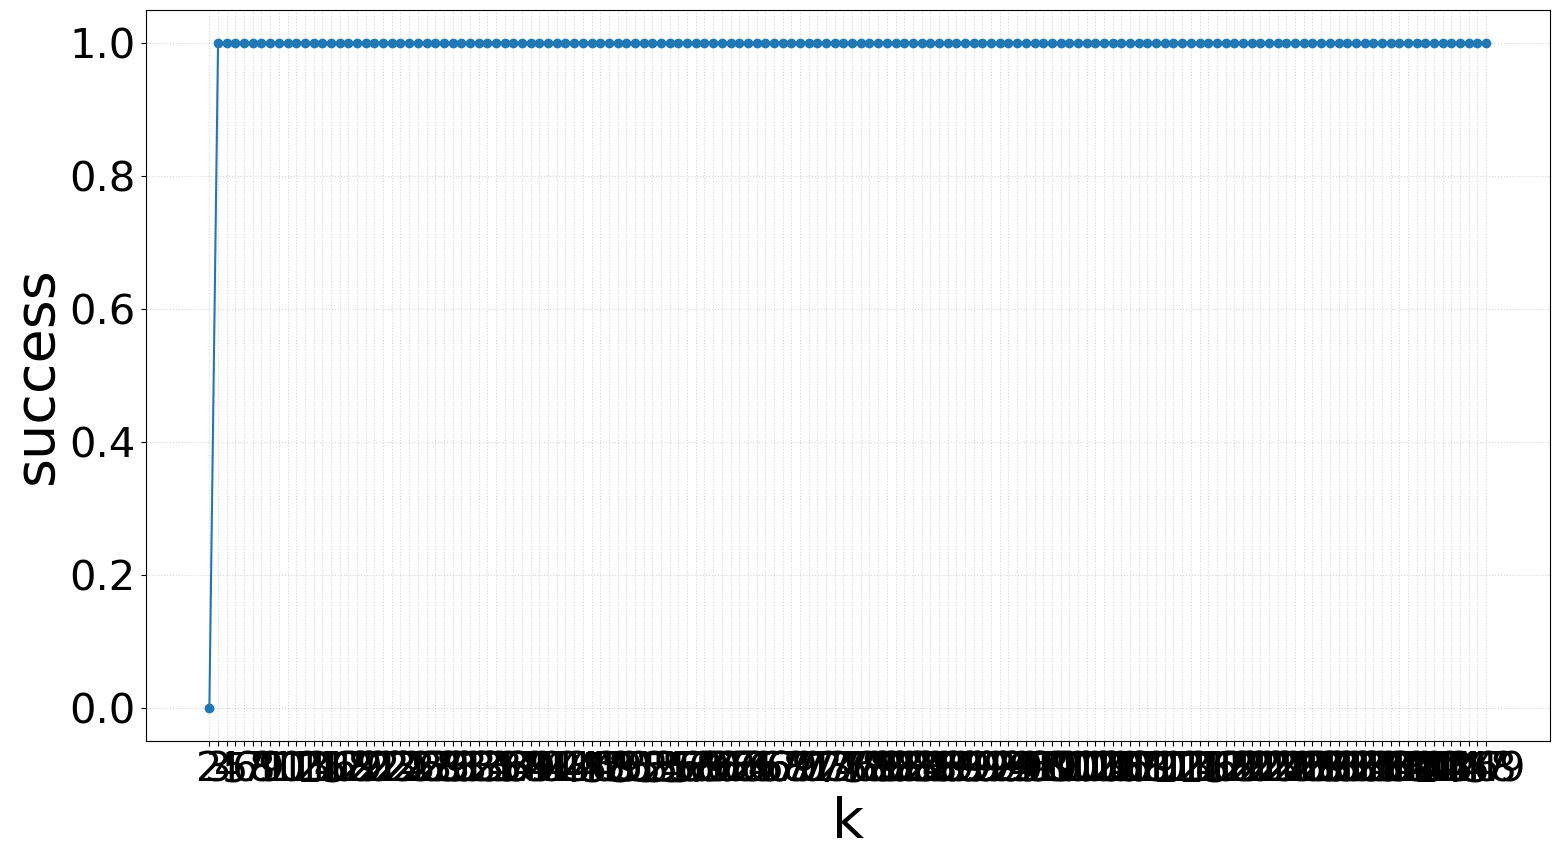

In [22]:
matplotlib.pyplot.plot(all_ks, successes, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('success')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## heatmap with labels

In [23]:
test.index.get_loc(iso1)

4649

In [24]:
observed_best_k = 9
best_index = all_ks.index(observed_best_k)
labels = groupings[best_index]

print(labels[test.index.get_loc(iso1)])
print(labels[test.index.get_loc(iso2)])

8
3


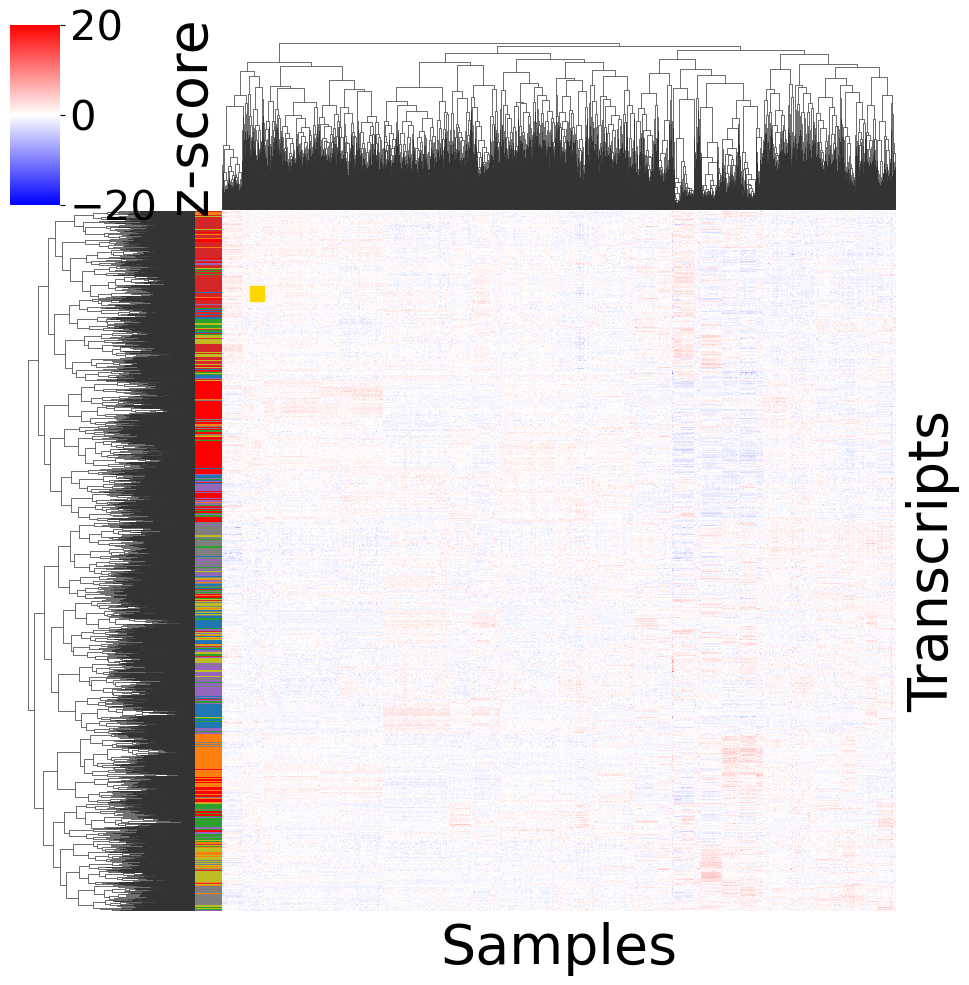

CPU times: user 1min 4s, sys: 280 ms, total: 1min 4s
Wall time: 1min 4s


In [25]:
%%time

color_options = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:gray', 'tab:olive', 'red', 'red']
k_colors = []
for i in range(len(test.index)):
  k_colors.append(color_options[labels[i]])

linkage_method = 'complete'
distance_metric = 'correlation'

clustergrid = seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric,
                   row_colors=k_colors
                  )

# adding where isoforms fell
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Rectangle((200, 500), width=100, height=100, color='gold'))
matplotlib.pyplot.show()

In [26]:
import matplotlib.patches
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Rectangle((3, 5), 1, 1, fill=False, edgecolor='black', lw=3))
matplotlib.pyplot.show()

In [27]:
#clustergrid.dendrogram_row.reordered_ind gives the indices of reordered rows

In [28]:
Run k-means and recover goodness and if isoforms are in different clusters. Then visualize in a heatmap.

SyntaxError: invalid syntax (2569969356.py, line 1)